# <center>Final Project; Algorithms in Modern Statistics </center>
### Submitted by: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv('archive/test_scores.csv')
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


## Part 1: EDA

### Visualizing Categorical Data

In [3]:
df.describe(include='object')

,school,school_setting,school_type,classroom,teaching_method,student_id,gender,lunch
count,2133,2133,2133,2133,2133,2133,2133,2133
unique,23,3,2,97,2,2133,2,2
top,GOOBU,Urban,Public,18K,Standard,2FHT3,Male,Does not qualify
freq,158,906,1582,31,1373,1,1077,1215


Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [4]:
df = df.drop(columns=['student_id'])

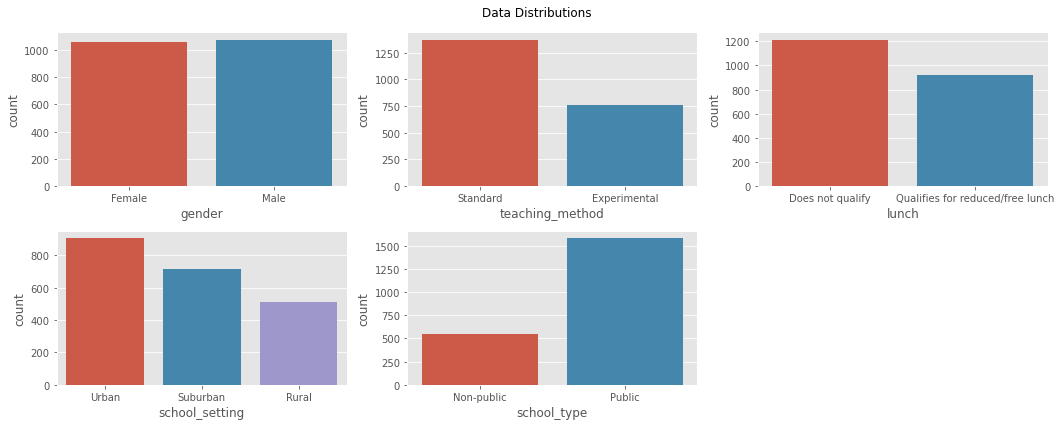

In [5]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

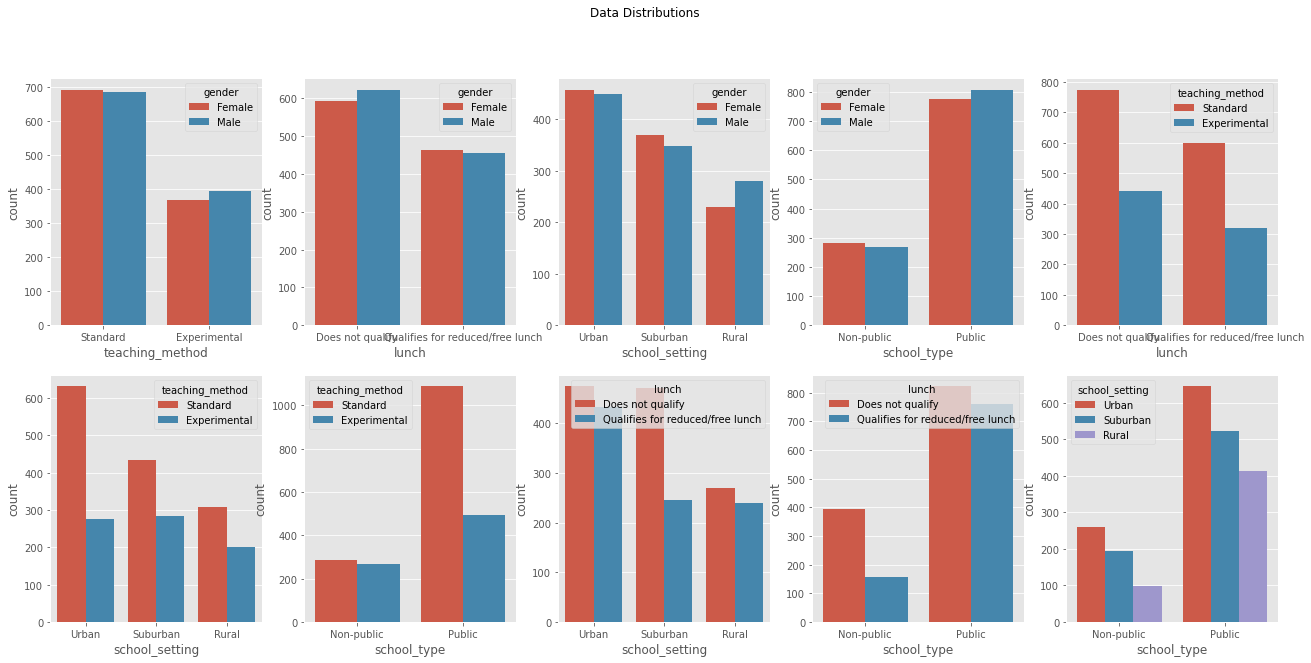

In [120]:
plt.figure(figsize=(22, 10))
plt.suptitle('Data Distributions splite')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

In [11]:
df.describe()

,n_student,pretest,posttest
count,2133.000000,2133.000000,2133.000000
mean,22.796531,54.955931,67.102203
std,4.228893,13.563101,13.986789
min,14.000000,22.000000,32.000000
25%,20.000000,44.000000,56.000000
50%,22.000000,56.000000,68.000000
75%,27.000000,65.000000,77.000000
max,31.000000,93.000000,100.000000
